# Lab 09-4. Batch Normalization

In [1]:
import torch
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# params
learning_rate = 1e-3
training_epochs = 15
batch_size = 100

**MNIST_batchnorm**

In [3]:
# nn_layers
linear1 = torch.nn.Linear(784, 32, bias=True)
linear2 = torch.nn.Linear( 32, 32, bias=True)
linear3 = torch.nn.Linear( 32, 10, bias=True)
relu    = torch.nn.ReLU()
bn1     = torch.nn.BatchNorm1d(32)
bn2     = torch.nn.BatchNorm1d(32)

nn_linear1 = torch.nn.Linear(784, 32, bias=True)
nn_linear2 = torch.nn.Linear( 32, 32, bias=True)
nn_linear3 = torch.nn.Linear( 32, 10, bias=True)

In [4]:
# model
bn_model = torch.nn.Sequential(linear1, bn1, relu,
                               linear2, bn2, relu,
                               linear3).to(device)

nn_model = torch.nn.Sequential(nn_linear1, relu,
                               nn_linear2, relu,
                               nn_linear3).to(device)

**Data Loader**

In [5]:
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [6]:
mnist_train = datasets.MNIST(root='MNIST_data/',
                             train=True,
                             transform=transforms.ToTensor(),
                             download=True)

mnist_test  = datasets.MNIST(root='MNIST_data/',
                             train=True,
                             transform=transforms.ToTensor(),
                             download=True)

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)

test_loader  = torch.utils.data.DataLoader(dataset=mnist_test,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)

**Training & Test**

In [8]:
criterion = torch.nn.CrossEntropyLoss().to(device)
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [9]:
train_total_batch = len(train_loader)
test_total_batch = len(test_loader)

train_losses = []
train_accs   = []

valid_losses = []
valid_accs   = []

for epoch in range(training_epochs):
    bn_model.train() # set the model to train mode (dropout=True)

    bn_avg_loss = 0
    nn_avg_loss = 0

    # train model
    bn_loss, nn_loss, bn_accuracy, nn_accuracy = 0, 0, 0, 0
    for X, Y in train_loader:
        X = X.view(-1, 28*28).to(device)
        Y = Y.to(device)

        bn_optimizer.zero_grad()
        bn_prediction = bn_model(X)
        bn_loss = criterion(bn_prediction, Y)
        bn_loss.backward()
        bn_optimizer.step()

        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()

        bn_avg_loss += bn_loss / train_total_batch
        nn_avg_loss += nn_loss / train_total_batch

    #test model
    with torch.no_grad():
        bn_model.eval() # set the model to evaluation mode (dropout=False)

        # test the model using test sets
        bn_loss, nn_loss, bn_accuracy, nn_accuracy = 0, 0, 0, 0
        for X, Y in train_loader:
            X = X.view(-1, 28*28).to(device)
            Y = Y.to(device)
        
            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_accuracy += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_accuracy += nn_correct_prediction.float().mean()

        bn_loss = bn_loss / test_total_batch
        nn_loss = nn_loss / test_total_batch

        bn_accuracy = bn_accuracy / test_total_batch
        nn_accuracy = nn_accuracy / test_total_batch

        train_losses.append([bn_loss, nn_loss])
        train_accs.append([bn_accuracy, nn_accuracy])

        print(f'[Epoch {epoch+1}-TRAIN] Batchnorm Loss(Acc): bn_loss:{bn_loss.item():.5f}(bn_acc:{bn_accuracy.item():.2f}) vs No Batchnorm Loss(Acc): nn_loss:{nn_loss.item():.5f}(nn_acc:{nn_accuracy.item():.2f})')

        # test the model using test sets
        bn_loss, nn_loss, bn_accuracy, nn_accuracy = 0, 0, 0, 0
        for X, Y in test_loader:
            X = X.view(-1, 28*28).to(device)
            Y = Y.to(device)
        
            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_accuracy += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_accuracy += nn_correct_prediction.float().mean()

    bn_loss = bn_loss / test_total_batch
    nn_loss = nn_loss / test_total_batch

    bn_accuracy = bn_accuracy / test_total_batch
    nn_accuracy = nn_accuracy / test_total_batch

    valid_losses.append([bn_loss, nn_loss])
    valid_accs.append([bn_accuracy, nn_accuracy])

    print(f'[Epoch {epoch+1}-VALID] Batchnorm Loss(Acc): bn_loss:{bn_loss.item():.5f}(bn_acc:{bn_accuracy.item():.2f}) vs No Batchnorm Loss(Acc): nn_loss:{nn_loss.item():.5f}(nn_acc:{nn_accuracy.item():.2f})')

print('learning finished')



[Epoch 1-TRAIN] Batchnorm Loss(Acc): bn_loss:0.16882(bn_acc:0.95) vs No Batchnorm Loss(Acc): nn_loss:0.28232(nn_acc:0.92)
[Epoch 1-VALID] Batchnorm Loss(Acc): bn_loss:0.16882(bn_acc:0.95) vs No Batchnorm Loss(Acc): nn_loss:0.28232(nn_acc:0.92)
[Epoch 2-TRAIN] Batchnorm Loss(Acc): bn_loss:0.10636(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.21589(nn_acc:0.94)
[Epoch 2-VALID] Batchnorm Loss(Acc): bn_loss:0.10636(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.21589(nn_acc:0.94)
[Epoch 3-TRAIN] Batchnorm Loss(Acc): bn_loss:0.07783(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.18349(nn_acc:0.95)
[Epoch 3-VALID] Batchnorm Loss(Acc): bn_loss:0.07783(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.18349(nn_acc:0.95)
[Epoch 4-TRAIN] Batchnorm Loss(Acc): bn_loss:0.06438(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.16464(nn_acc:0.95)
[Epoch 4-VALID] Batchnorm Loss(Acc): bn_loss:0.06438(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.16464(nn_acc:0.95)
[Epoch 5-TRAIN] Batchnor

**Visualization**

In [23]:
import matplotlib.pylab as plt

def plot(lists:list, ylim=None, title=None):
    bn = [i[0] for i in lists]
    nn = [i[1] for i in lists]

    if torch.cuda.is_available():
        # TypeError: can't convert cuda:0 device type tensor to numpy.
        # Use Tensor.cpu() to copy the tensor to host memory first.
        bn = torch.stack(bn).cpu()
        nn = torch.stack(nn).cpu()

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='with bn')
    plt.plot(nn, label='with nn')

    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)

    plt.legend()
    plt.grid('on')
    plt.show()

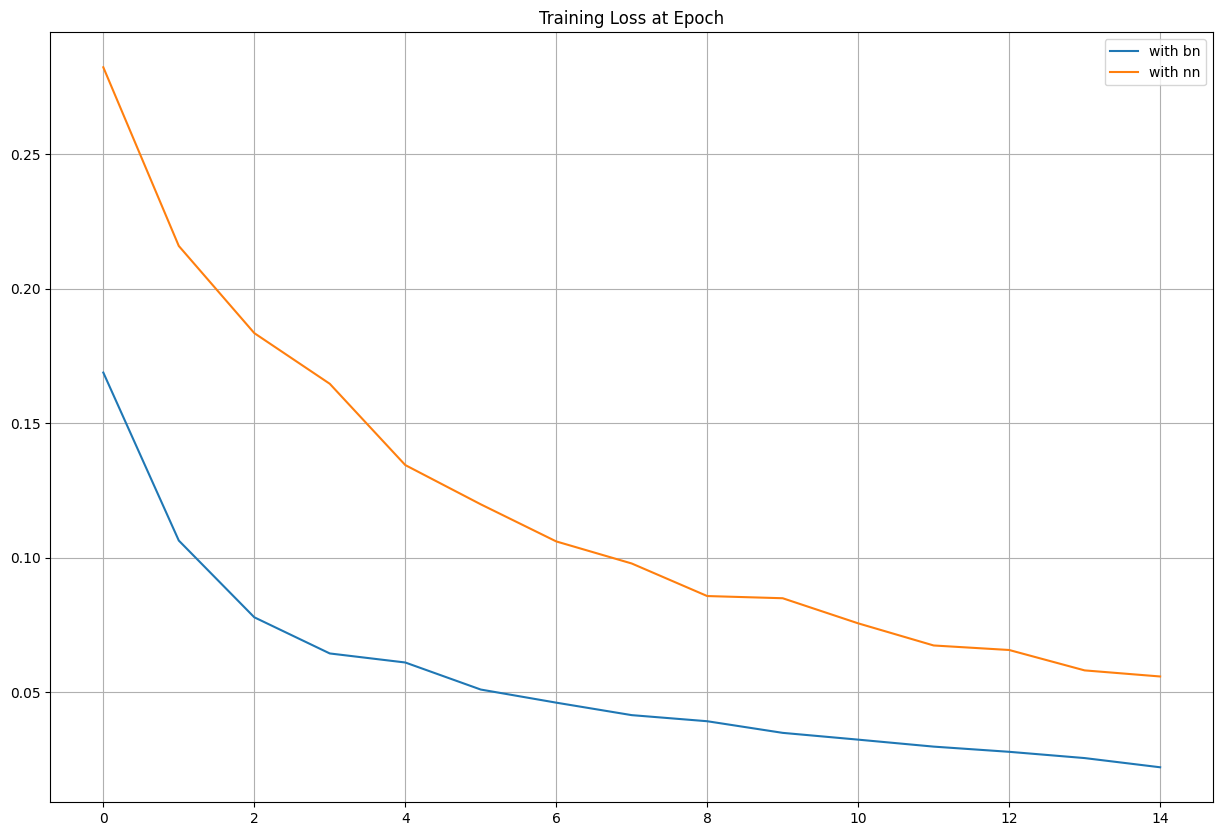

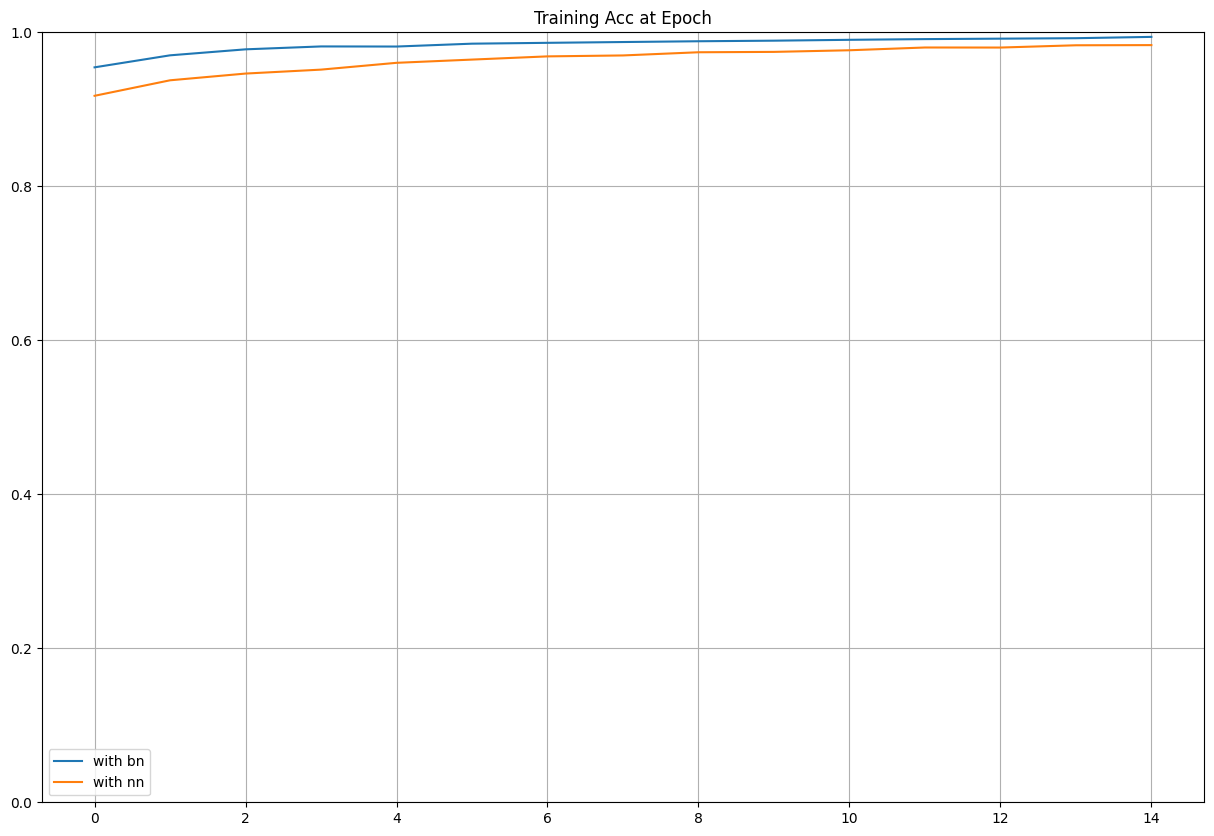

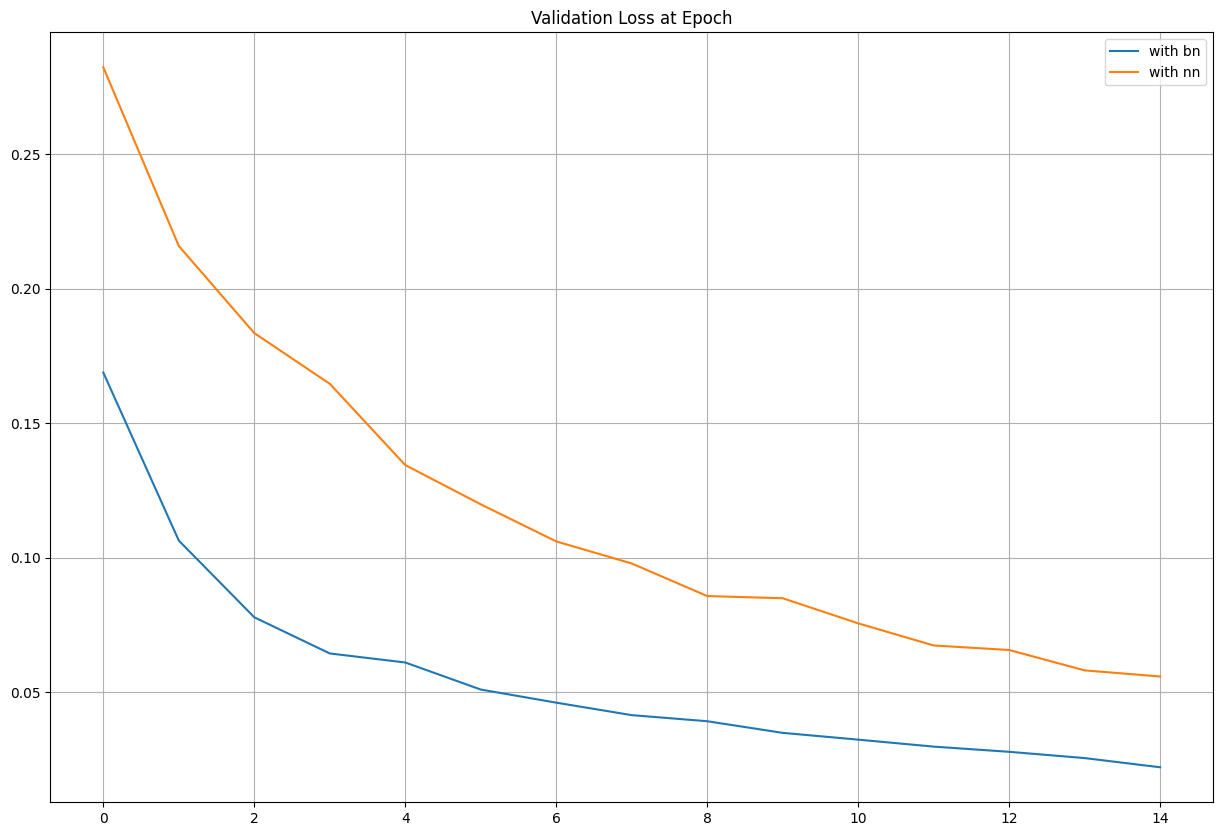

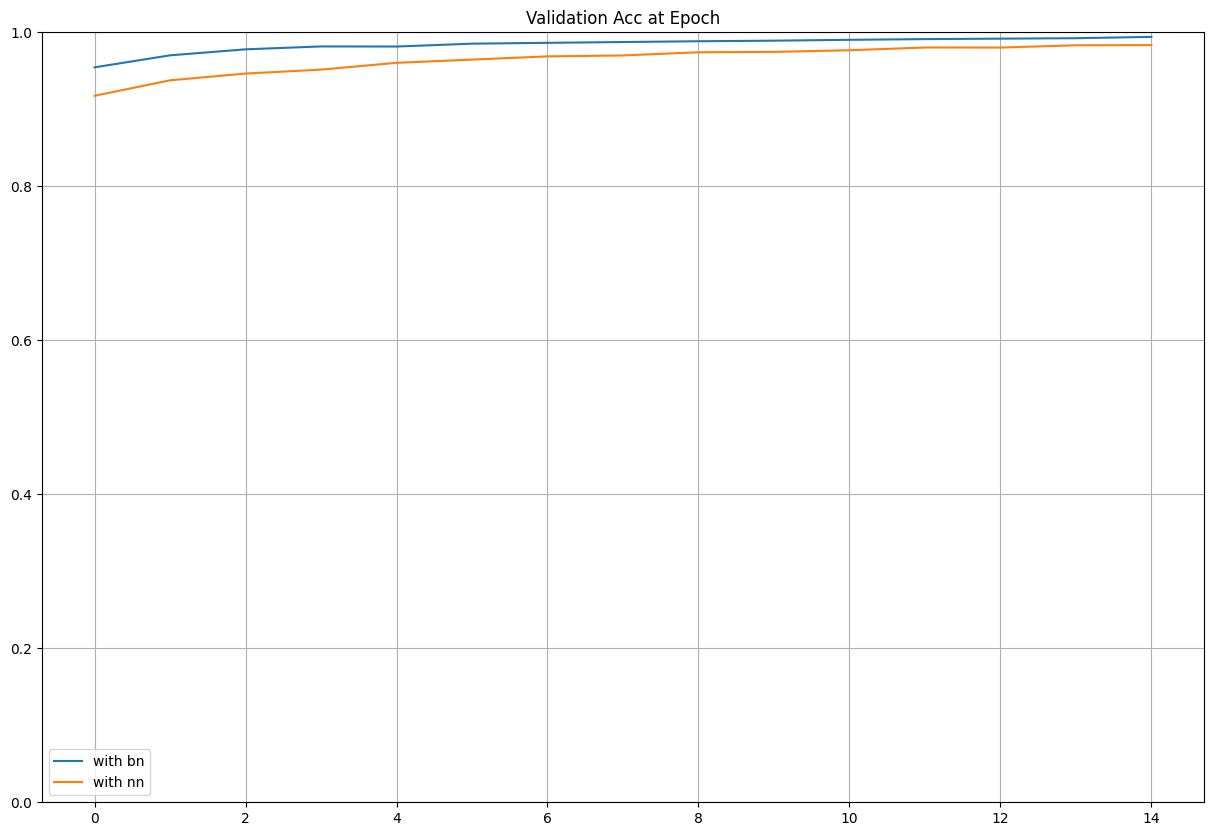

In [24]:
plot(train_losses, title='Training Loss at Epoch')
plot(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot(valid_losses, title='Validation Loss at Epoch')
plot(valid_accs, [0, 1.0], title='Validation Acc at Epoch')